This notebook is made for rechecking the lower bound of the heteroscedastic model.

It shows that the lower bound works well, and that rather the model is a bit problematic.

In [1]:
from gaussian_toolbox import pdf, approximate_conditional
import numpy as np 
from jax import numpy as jnp
import jax
from matplotlib import pyplot as plt
from jax import config
config.update("jax_enable_x64", True)

Dy = 3
Da = Dy
Dk = 1
Dx = 1
R = 1
Du = 1

M = jnp.array([jnp.eye(Dy)])[:, :, :Dx]
b = jnp.array([jnp.zeros(Dy)])

#Sigma = jnp.array([jnp.eye(Dy)]) + .1
#mat = np.random.randn(Dy, Dy)
#Q, R = np.linalg.qr(mat)
#U = Q[:, :Du]
A = jnp.array(np.random.randn(1, Dy, Da))
W = jnp.array(np.random.randn(Dk, Dx + 1))

#cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
cond = approximate_conditional.HeteroscedasticCoshM1Conditional(M=M, b=b, A=A, W=W)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Check if cosh is rightly implemented

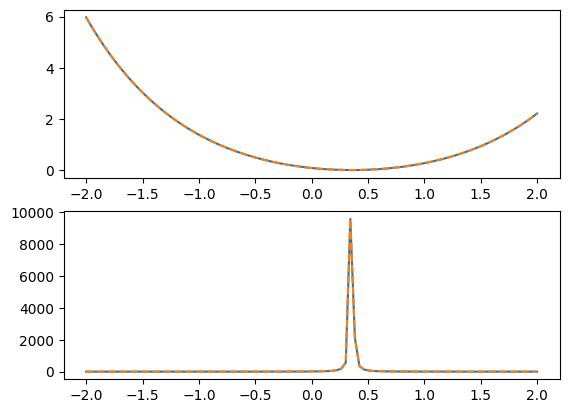

In [6]:
x = jnp.array([jnp.linspace(-2,2,100)]).T
cosh_gt = cond.link_function(cond.linear_layer(x))[:,0]
cosh_np = jnp.cosh((jnp.dot(W[:, 1:], x.T) + W[:, 0])) - 1
plt.subplot(2,1,1)
plt.plot(x, cosh_gt.T)
plt.plot(x, cosh_np.T, '--')
plt.subplot(2,1,2)
plt.plot(x, 1./cosh_gt.T)
plt.plot(x, 1./cosh_np.T, '--')

## Check if covariance matrix is computed correctly

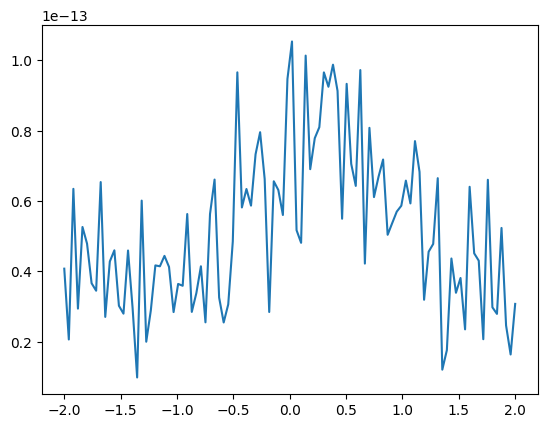

In [7]:
cov_gt, prec_gt, ln_det_cov_gt = cond.get_conditional_cov(x, invert=True)
plt.plot(x, jnp.sum(jnp.sum(jnp.abs(jnp.einsum('abc,acd->abd', cov_gt, prec_gt) - jnp.eye(Dy)[None]) / jnp.abs(cov_gt), axis=1), axis=1))

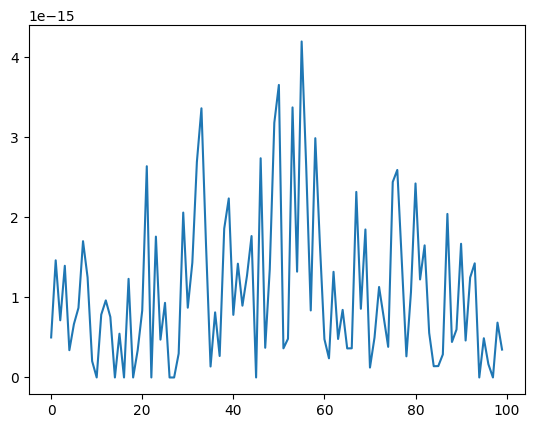

In [8]:
ln_det_cov_np = jnp.linalg.slogdet(cov_gt)[1]
plt.plot(jnp.abs(ln_det_cov_gt - ln_det_cov_np) / jnp.abs(ln_det_cov_gt))

In [10]:
Sigma = jnp.einsum('abc,adc->abd', A, A)
cov_mat_np = Sigma + jnp.einsum("abc,dc->abd", jnp.einsum("ab,bc->cab", A[0,:,:Dk], diag), A[0,:,:Dk])
plt.plot(x, jnp.sum(jnp.sum(jnp.abs(cov_mat_np - cov_gt) / jnp.abs(cov_gt), axis=1), axis=1))

NameError: name 'diag' is not defined

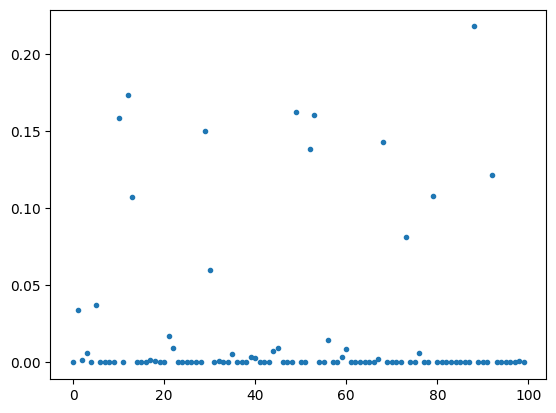

In [12]:
y = jnp.array(np.random.randn(100,Dy))
plt.plot(cond(x).evaluate(y, element_wise=True), '.')

(1, 100)


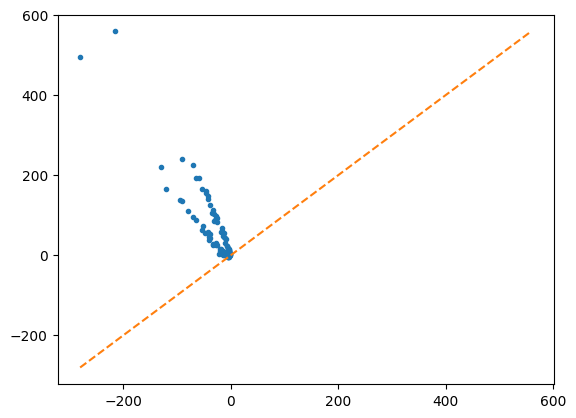

In [14]:
from jax import random as jrand
cond = approximate_conditional.HeteroscedasticExpConditional(M=M, b=b, A=A, W=W)
pX = pdf.GaussianPDF(mu=jnp.zeros(Dx)[None], Sigma=jnp.eye(Dx)[None])
key = jrand.PRNGKey(0)
x_samples = pX.sample(key, 10000)
int_log_cond_y_np = jnp.mean(cond(x_samples[:,0]).evaluate_ln(y), axis=0)
px = pdf.GaussianPDF(mu=jnp.tile(pX.mu, (100,1)), Sigma=jnp.tile(pX.Sigma, (100,1,1)))
int_log_cond_y_gt = cond.integrate_log_conditional_y(p_x=px, y= y)

plt.plot(int_log_cond_y_np, int_log_cond_y_gt, '.')
plt.plot([jnp.amin(jnp.stack([int_log_cond_y_gt, int_log_cond_y_np])),jnp.amax(jnp.stack([int_log_cond_y_gt, int_log_cond_y_np]))], 
         [jnp.amin(jnp.stack([int_log_cond_y_gt, int_log_cond_y_np])),jnp.amax(jnp.stack([int_log_cond_y_gt, int_log_cond_y_np]))], '--')

### Check log determinant

In [15]:
from jax import lax
import jax

ln_det_cov_gt_arr = np.zeros(50)
ln_det_cov_np_arr = np.zeros(50)

for i in range(50):
    M = jnp.array([jnp.eye(Dy)])[:, :, :Dx]
    b = jnp.array([jnp.zeros(Dy)])

    #Sigma = jnp.array([jnp.eye(Dy)]) + .1
    #mat = np.random.randn(Dy, Dy)
    #Q, R = np.linalg.qr(mat)
    #U = Q[:, :Du]
    A = jnp.array(np.random.randn(1, Dy, Da))
    W = jnp.array(np.random.randn(Dk, Dx + 1))

    cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
    pX = pdf.GaussianPDF(mu=jnp.zeros(Dx)[None], Sigma=jnp.eye(Dx)[None])
    ln_det_cov_np = jnp.mean(cond(x_samples[:,0]).ln_det_Sigma)
    def scan_body_function(carry, args_i):
        W_i, u_i = args_i
        omega_star_i, omega_dagger_i, _ = lax.stop_gradient(
            cond._get_omega_star_i(W_i, u_i, px, y)
        )
        uRu_i, log_lb_sum_i = cond._get_lb_i(
            W_i, u_i, omega_star_i, omega_dagger_i, px, y
        )
        result = (uRu_i, log_lb_sum_i)
        return carry, result

    _, result = lax.scan(scan_body_function, None, (cond.W, cond.U.T))
    uRu, log_lb_sum = result
    ln_det_cov_gt = log_lb_sum + cond.ln_det_Sigma
    ln_det_cov_gt_arr[i] = ln_det_cov_gt[0,0]
    ln_det_cov_np_arr[i] = ln_det_cov_np
#assert jnp.alltrue(jnp.less_equal(ln_det_cov_np_arr, ln_det_cov_gt_arr))

AttributeError: 'FullHCCovGaussianConditional' object has no attribute 'U'

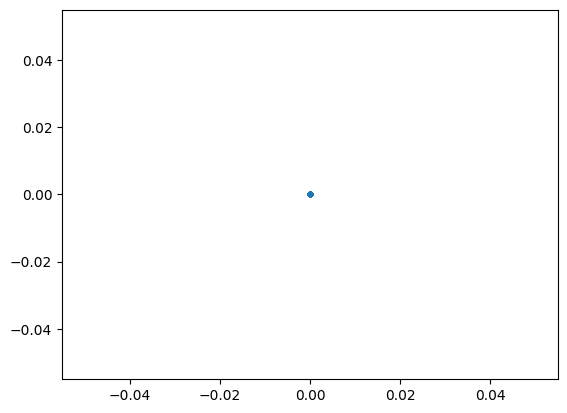

In [16]:
plt.plot(ln_det_cov_np_arr, ln_det_cov_gt_arr, '.')
plt.plot([jnp.amin(jnp.stack([ln_det_cov_gt_arr, ln_det_cov_np_arr])),jnp.amax(jnp.stack([ln_det_cov_gt_arr, ln_det_cov_np_arr]))],
            [jnp.amin(jnp.stack([ln_det_cov_gt_arr, ln_det_cov_np_arr])),jnp.amax(jnp.stack([ln_det_cov_gt_arr, ln_det_cov_np_arr]))], '--')

# Check quadratic term

In [17]:
mu = cond.get_conditional_mu(x_samples[:,0])[0]
cov, prec, ln_det_cov_gt = cond.get_conditional_cov(x_samples[:,0], invert=True)
mat = prec - jnp.linalg.inv(cond.Sigma)
y_mu = y[None] - mu[:,None]

In [18]:
res_np = jnp.mean(jnp.einsum('abc, abc->ab', jnp.einsum('abc,adc->adb', mat, y_mu), y_mu), axis=0)

In [19]:
res_gt = -jnp.sum(uRu,axis=0)

NameError: name 'uRu' is not defined

In [34]:
plt.plot(res_np, res_gt, '.')
plt.plot([jnp.amin(jnp.stack([res_gt, res_np])),jnp.amax(jnp.stack([res_gt, res_np]))],
         [jnp.amin(jnp.stack([res_gt, res_np])),jnp.amax(jnp.stack([res_gt, res_np]))], '--')

NameError: name 'res_gt' is not defined

### Check diagonal term 

In [35]:
cosh = cond.exp_h_minus(x_samples[:,0]) + cond.exp_h_plus(x_samples[:,0])
G_np = jnp.mean((cosh-1)/cosh, axis=1)

In [36]:
cond._get_omega_star_i(W, U.T, px, y)

AttributeError: 'FullHCCovGaussianConditional' object has no attribute '_get_omega_star_i'

In [37]:
from gaussian_toolbox import pdf, factor
from jaxtyping import Array, Float
from typing import Tuple

def _get_G_i(
        cond,
        W_i: Float[Array, "Dx+1"],
        u_i: Float[Array, "Dy"],
        omega_star: Float[Array, "N"],
        p_x: pdf.GaussianPDF,
        y: Float[Array, "N Dy"],
    ) -> Tuple[Float[Array, "N"], Float[Array, "N"]]:
        # phi = pdf.GaussianPDF(**phi_dict)
        # beta = self.beta[iu:iu + 1]
        # Lower bound for \mathbb{E}[ln (sigma_x^2 + f(h))]
        G = p_x.R
        w_i = W_i[1:].reshape((1, -1))
        v = jnp.tile(w_i, (G, 1))
        b_i = W_i[:1]
        u_i = u_i.reshape((-1, 1))
        # Lower bound for \mathbb{E}[ln (sigma_x^2 + f(h))]
        g_omega = cond.g(omega_star)
        nu = -g_omega[:, None] * b_i * w_i
        nu_plus = w_i + nu
        nu_minus = -w_i + nu
        f_omega_star = cond.f(omega_star)
        ln_beta = -jnp.where(
            jnp.isclose(f_omega_star, 0), 0, jnp.log(1 + f_omega_star)
        ) - 0.5 * g_omega * (b_i**2 - omega_star**2)
        ln_beta_plus = ln_beta + b_i - jnp.log(2)
        ln_beta_minus = ln_beta - b_i - jnp.log(2)
        # Create OneRankFactors
        g_omega = jnp.clip(g_omega, a_min=1e-4)
        exp_factor_plus = factor.OneRankFactor(
            v=v, g=g_omega, nu=nu_plus, ln_beta=ln_beta_plus
        )
        exp_factor_minus = factor.OneRankFactor(
            v=v, g=g_omega, nu=nu_minus, ln_beta=ln_beta_minus
        )
        one_factor = factor.OneRankFactor(v=v, g=g_omega, nu=nu, ln_beta=ln_beta)
        # Create the two measures
        exp_phi_plus = p_x.hadamard(exp_factor_plus, update_full=True)
        exp_phi_minus = p_x.hadamard(exp_factor_minus, update_full=True)
        phi_one = p_x.hadamard(one_factor, update_full=True)

        mat1 = -cond.M[0]
        vec1 = y - cond.b[0]
        vec1_projected = jnp.einsum("ba,cb->ca", cond.L_inv[0], vec1)
        mat1_projected = jnp.einsum("ba,bc->ac", cond.L_inv[0], mat1)
        G_plus = exp_phi_plus.integrate(
            "(Ax+a)(Bx+b)'",
            A_mat=mat1_projected,
            a_vec=vec1_projected,
            B_mat=mat1_projected,
            b_vec=vec1_projected,
        )
        G_minus = exp_phi_minus.integrate(
            "(Ax+a)(Bx+b)'",
            A_mat=mat1_projected,
            a_vec=vec1_projected,
            B_mat=mat1_projected,
            b_vec=vec1_projected,
        )
        G_one = phi_one.integrate(
            "(Ax+a)(Bx+b)'",
            A_mat=mat1_projected,
            a_vec=vec1_projected,
            B_mat=mat1_projected,
            b_vec=vec1_projected,
        )
        G = G_plus + G_minus - G_one
        return G


In [38]:
_get_G_i(cond, W[0], U[0], omega_star, p_x, y)

NameError: name 'U' is not defined

# Test lower bound

In [87]:
%load_ext autoreload
%autoreload 2

from gaussian_toolbox import pdf, approximate_conditional, factor
import numpy as np 
from jax import numpy as jnp
import jax
from matplotlib import pyplot as plt
from jax import config, lax
config.update("jax_enable_x64", True)

Dy = 1
Dx = 1
Da = 1
Dk = 1
R = 1
Du = 1

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
M = jax.random.normal(subkey, shape=(1, Dy, Dx))
b = jnp.array([jnp.zeros(Dy)])

#Sigma = jnp.array([jnp.eye(Dy)]) + .1
#mat = np.random.randn(Dy, Dy)
#Q, R = np.linalg.qr(mat)
#U = Q[:, :Du]
A = jnp.array(np.random.randn(1, Dy, Da))
W = jnp.array(np.random.randn(Dk, Dx + 1))

#cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
#cond = approximate_conditional.HeteroscedasticExpConditional(M=M, b=b, A=A, W=W)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
num_samples = 1000
key, subkey = jax.random.split(key)
y = jax.random.normal(key, (10, Dy))
key, subkey = jax.random.split(key)
mu = jax.random.normal(subkey, (1,Dx))
key, subkey = jax.random.split(key)
rand_mat = jax.random.uniform(subkey, (Dx, Dx))
Sigma = jnp.array(jnp.eye(Dx) + jnp.dot(rand_mat, rand_mat.T))[None]
px = pdf.GaussianPDF(mu=mu, Sigma=Sigma)
p_x_tiled = pdf.GaussianPDF(mu=jnp.tile(mu, (y.shape[0], 1)), Sigma=jnp.tile(Sigma, (y.shape[0], 1, 1)))
key, subkey = jax.random.split(key)
x_samples = px.sample(subkey, num_samples)[:,0]

In [89]:
Sigma_y_x, Lambda_y_x, ln_det_Sigma_y_x = cond.get_conditional_cov(x_samples, True)
mu_y_x = cond.get_conditional_mu(x_samples)
y_mu = y[:,None] - mu_y_x
quadratic_term = - .5 * jnp.mean(jnp.einsum("abc,bcd,abd->ab", y_mu, Lambda_y_x, y_mu), axis=1)
log_det = ln_det_Sigma_y_x.mean()
sampled_log_cond = quadratic_term - .5 * log_det - .5 * Dy * jnp.log(2 * jnp.pi)


In [90]:
sampled_log_cond2 = jnp.mean(cond(x_samples).evaluate_ln(y), axis=0)

In [91]:
bounded_log_cond = jnp.empty((10,))
integrate_log_conditional_y = jax.jit(cond.integrate_log_conditional_y)
for i in range(10):
    bounded_log_cond_i = cond.integrate_log_conditional_y(p_x=px, y=y[i:i+1])
    bounded_log_cond = bounded_log_cond.at[i].set(bounded_log_cond_i[0])

(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)
(1,) (1,) (1,)
(1, 1)


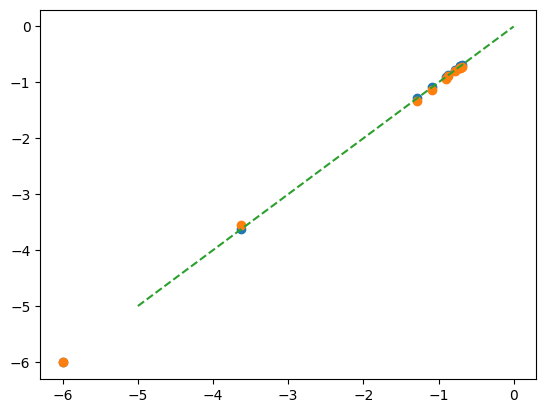

In [92]:
plt.plot(sampled_log_cond, sampled_log_cond2, "o")
plt.plot(sampled_log_cond, bounded_log_cond, "o")
plt.plot([-5, 0], [-5, 0], "--")

This is not lower bound, but upper bound.

Let's check the determinant.

In [31]:
px.integration_dict.keys()

dict_keys(['1', 'x', '(Ax+a)', "xx'", "(Ax+a)'(Bx+b)", "(Ax+a)(Bx+b)'", "(Ax+a)(Bx+b)'(Cx+c)", "(Ax+a)'(Bx+b)(Cx+c)'", "x(A'x + a)x'", "xb'xx'", "(Ax+a)'(Bx+b)(Cx+c)'(Dx+d)", "(Ax+a)(Bx+b)'(Cx+c)(Dx+d)'", 'log u(x)'])

In [32]:
b = cond.W[:,0]
w = cond.W[:,1:]
omega_dagger = jnp.sqrt(px.integrate("(Ax+a)'(Bx+b)", A_mat=w, a_vec=b, B_mat=w, b_vec=b))

def k_tmp(omega_dagger, px):
    Eh2 = px.integrate("(Ax+a)'(Bx+b)", A_mat=w, a_vec=b, B_mat=w, b_vec=b)
    Eh = px.integrate("(Ax+a)", A_mat=w, a_vec=b)
    return .5 * Eh + jnp.log(jnp.cosh(omega_dagger / 2.)) + .25 * jnp.tanh(omega_dagger / 2.) / omega_dagger * (Eh2 - omega_dagger ** 2) + jnp.log(2.)

def lb_log_det_tmp(omega_dagger, px):
    k_omega = k_tmp(omega_dagger, px)
    lower_bound_log_det = cond.ln_det_Sigma + k_omega
    return lower_bound_log_det

In [33]:
# Functions to integrate in toolbox
def _get_omega_dagger(p_x: pdf.GaussianPDF, W_i: jnp.ndarray) -> jnp.ndarray:
    b = W_i[None,:1]
    w = W_i[None,1:]
    omega_dagger = jnp.sqrt(p_x.integrate("(Ax+a)'(Bx+b)", A_mat=w, a_vec=b, B_mat=w, b_vec=b))
    return omega_dagger

#def k_func(p_x: pdf.GaussianPDF, W_i: jnp.ndarray, omega_dagger: jnp.ndarray):
#    b = W_i[None,:1]
#    w = W_i[None,1:]
#    Eh2 = p_x.integrate("(Ax+a)'(Bx+b)", A_mat=w, a_vec=b, B_mat=w, b_vec=b)
#    return jnp.log(jnp.cosh(omega_dagger)) + .5 * jnp.tanh(omega_dagger) / omega_dagger * (Eh2 - omega_dagger ** 2)


def k_func(p_x: pdf.GaussianPDF, W_i, omega_dagger):
    b = W_i[None,:1]
    w = W_i[None,1:]
    Eh2 = p_x.integrate("(Ax+a)'(Bx+b)", A_mat=w, a_vec=b, B_mat=w, b_vec=b)
    Eh = p_x.integrate("(Ax+a)", A_mat=w, a_vec=b)
    return .5 * Eh + jnp.log(jnp.cosh(omega_dagger / 2.)) + .25 * jnp.tanh(omega_dagger / 2.) / omega_dagger * (Eh2 - omega_dagger ** 2) + jnp.log(2.)

def get_lb_log_det(self, p_x: pdf.GaussianPDF):
    omega_dagger = lax.stop_gradient(jax.vmap(lambda W: _get_omega_dagger(p_x=p_x, W_i=W), in_axes=(0,))(self.W))
    k_omega = jax.vmap(lambda W, omega: k_func(p_x=p_x, W_i=W, omega_dagger=omega))(self.W, omega_dagger)
    lower_bound_log_det = self.ln_det_Sigma + jnp.sum(k_omega, axis=0)
    return lower_bound_log_det


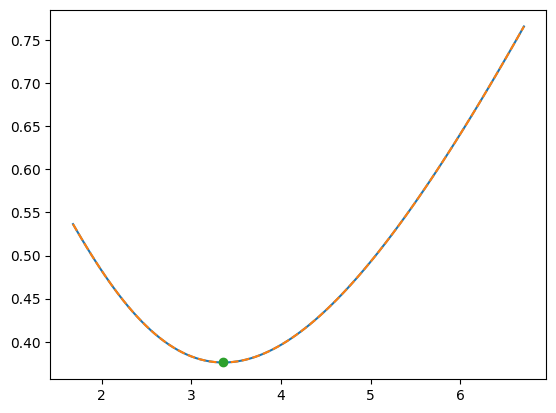

In [34]:
omega_range = jnp.linspace(.5 * omega_dagger,2 * omega_dagger, 100)
plt.plot(omega_range, k_tmp(omega_range, px=px)[:,0])
plt.plot(omega_range, jax.vmap(lambda omega: k_func(p_x=px, W_i=cond.W[0], omega_dagger=omega))(omega_range)[:,0], '--')
plt.plot(omega_dagger, k_tmp(omega_dagger, px=px)[0], "o")

In [35]:
lower_bound_log_det_tmp = lb_log_det_tmp(omega_range, px=px)
lower_bound_log_det = cond.get_lb_log_det(p_x=px)

(1, 1)


In [36]:
lower_bound_log_det

Array([-6.15107365], dtype=float64)

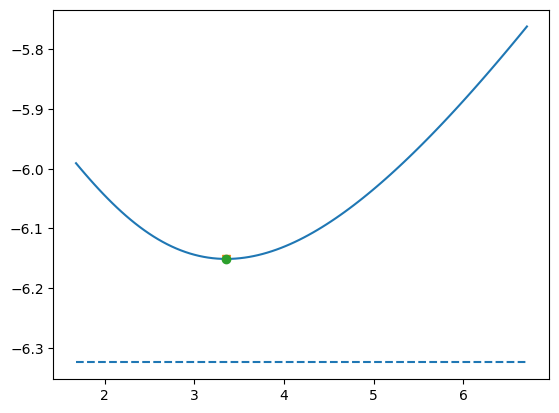

In [37]:
plt.plot(omega_range, lower_bound_log_det_tmp[:,0])
plt.plot(omega_dagger, get_lb_log_det(cond, p_x=px), "v")
plt.plot(omega_dagger, lb_log_det_tmp(omega_dagger, px), "o")
plt.hlines(log_det, omega_range[0], omega_range[-1], linestyles="--")

# Quadratic term

In [38]:
# [Du, R]
from jax import lax
omega_dagger = jax.vmap(lambda W:_get_omega_dagger(p_x=p_x_tiled, W_i=W), out_axes=1)(cond.W)

def _update_omega_star(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray, W_i: jnp.ndarray, U_i: jnp.ndarray, omega_star: jnp.ndarray):
    b = W_i[None,:1]
    w = W_i[None,1:]
    
    g_1 = jnp.tanh(omega_star) / omega_star
    nu_1 = - (jnp.tanh(omega_star) / omega_star)[:,None] * b * w
    ln_beta_1 = - jnp.log(jnp.cosh(omega_star)) - .5 * jnp.tanh(omega_star) / omega_star * (b[0] ** 2 - omega_star ** 2)
    phi_1 = p_x.hadamard(factor.OneRankFactor(v=jnp.tile(w, (omega_star.shape[0], 1)), g=g_1, nu=nu_1, ln_beta=ln_beta_1), update_full=True)
    phi_plus = phi_1.hadamard(factor.LinearFactor(nu=w, ln_beta=b-jnp.log(2.)), update_full=True)
    phi_minus = phi_1.hadamard(factor.LinearFactor(nu=-w, ln_beta=-b-jnp.log(2.)), update_full=True)

    # Quartic integral

    projected_M = jnp.einsum('acb,acd->abd', cond.L_inv, cond.M)
    projected_yb = jnp.einsum('acb,ac->ab', cond.L_inv, y - cond.b)
    U_projected_M = jnp.einsum('ab,cad->cbd', U_i[:,None], projected_M)
    U_projected_yb = jnp.einsum('ab,ca->cb', U_i[:,None], projected_yb)
    
    quartic_1 = phi_1.integrate("(Ax+a)'(Bx+b)(Cx+c)'(Dx+d)", A_mat=w, a_vec=b, B_mat=w, b_vec=b, 
                                C_mat=-U_projected_M, c_vec=U_projected_yb, D_mat=-U_projected_M, d_vec=U_projected_yb)
    quartic_plus = phi_plus.integrate("(Ax+a)'(Bx+b)(Cx+c)'(Dx+d)", A_mat=w, a_vec=b, B_mat=w, b_vec=b, 
                                      C_mat=-U_projected_M, c_vec=U_projected_yb, D_mat=-U_projected_M, d_vec=U_projected_yb)
    quartic_minus = phi_minus.integrate("(Ax+a)'(Bx+b)(Cx+c)'(Dx+d)", A_mat=w, a_vec=b, B_mat=w, b_vec=b, 
                                        C_mat=-U_projected_M, c_vec=U_projected_yb, D_mat=-U_projected_M, d_vec=U_projected_yb)

    quartic_integral = - quartic_1 + quartic_plus + quartic_minus
    # Quadratic integral
    quadratic_1 = phi_1.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)
    quadratic_plus = phi_plus.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)
    quadratic_minus = phi_minus.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)

    quadratic_integral = - quadratic_1 + quadratic_plus + quadratic_minus

    omega_star = jnp.sqrt(quartic_integral / quadratic_integral)[0]
    return omega_star

def _get_omega_star(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray, W_i: jnp.ndarray, U_i: jnp.ndarray):
    omega_star = _get_omega_dagger(p_x=p_x, W_i=W_i)
    omega_dagger = omega_star + 1.
    cond_func = lambda val: jnp.max(jnp.abs(val[0] - val[1])) > 1e-5
    body_func = lambda val: (_update_omega_star(cond, p_x=p_x, y=y, W_i=W_i, U_i=U_i, omega_star=val[0]), val[0])
    omega_star, _ = lax.while_loop(cond_func, body_func, (omega_star, omega_dagger))
    return omega_star

def get_lb_heteroscedastic_term_i(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray, W_i: jnp.ndarray, U_i: jnp.ndarray):
    omega_star = lax.stop_gradient(_get_omega_star(cond, p_x=p_x, y=y, W_i=W_i, U_i=U_i))
    b = W_i[None,:1]
    w = W_i[None,1:]
    g_1 = jnp.tanh(omega_star) / omega_star
    nu_1 = - (jnp.tanh(omega_star) / omega_star)[:,None] * b * w
    ln_beta_1 = - jnp.log(jnp.cosh(omega_star)) - .5 * jnp.tanh(omega_star) / omega_star * (b ** 2 - omega_star ** 2)
    phi_1 = p_x.hadamard(factor.OneRankFactor(v=jnp.tile(w, (omega_star.shape[0], 1)), g=g_1, nu=nu_1, ln_beta=ln_beta_1), update_full=True)
    phi_plus = phi_1.hadamard(factor.LinearFactor(nu=w, ln_beta=b-jnp.log(2.)), update_full=True)
    phi_minus = phi_1.hadamard(factor.LinearFactor(nu=-w, ln_beta=-b-jnp.log(2.)), update_full=True)
    # Quadratic integral
    projected_M = jnp.einsum('acb,acd->abd', cond.L_inv, cond.M)
    projected_yb = jnp.einsum('acb,ac->ab', cond.L_inv, y - cond.b)
    U_projected_M = jnp.einsum('ab,cad->cbd', U_i[:,None], projected_M)
    U_projected_yb = jnp.einsum('ab,ca->cb', U_i[:,None], projected_yb)
    quadratic_1 = phi_1.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)
    quadratic_plus = phi_plus.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)
    quadratic_minus = phi_minus.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)

    G_i = - quadratic_1 + quadratic_plus + quadratic_minus
    return G_i

def get_lb_quadratic_term(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray):
    projected_M = jnp.einsum('acb,acd->abd', cond.L_inv, cond.M)
    projected_yb = jnp.einsum('acb,ac->ab', cond.L_inv, y - cond.b)
    homoscedastic_term = p_x.integrate("(Ax+a)'(Bx+b)", A_mat=-projected_M, a_vec=projected_yb, B_mat=-projected_M, b_vec=projected_yb)
    get_lb_heteroscedastic_term = jnp.sum(jax.vmap(lambda W, U: get_lb_heteroscedastic_term_i(cond, p_x_tiled, y, W, U))(cond.W, cond.U.T), axis=0)
    return homoscedastic_term - get_lb_heteroscedastic_term
                   


In [39]:
# [Du, R]
from jax import lax
omega_dagger = jax.vmap(lambda W:_get_omega_dagger(p_x=p_x_tiled, W_i=W), out_axes=1)(cond.W)

def _update_omega_star(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray, W_i: jnp.ndarray, a_i: jnp.ndarray, omega_star: jnp.ndarray):
    b = W_i[None,:1]
    w = W_i[None,1:]
    
    g_1 = .5 * jnp.tanh(omega_star/2.) / omega_star
    nu_1 = - .5 * ((jnp.tanh(omega_star/2.) / omega_star)[:,None] * b + 1) * w
    ln_beta_1 = - jnp.log(jnp.cosh(omega_star / 2.)) - .25 * jnp.tanh(omega_star / 2.) / omega_star * (b ** 2 - omega_star ** 2) - .5 * b - jnp.log(2.)
    phi = p_x.hadamard(factor.OneRankFactor(v=jnp.tile(w, (omega_star.shape[0], 1)), g=g_1, nu=nu_1, ln_beta=ln_beta_1), update_full=True)

    # Quartic integral

    projected_M = jnp.einsum('ab,cad->cbd', a_i[:,None], cond.M)
    projected_yb = jnp.einsum('ab,ca->cb', a_i[:,None], y - cond.b)
    quartic_integral = phi.integrate("(Ax+a)'(Bx+b)(Cx+c)'(Dx+d)", A_mat=w, a_vec=b, B_mat=w, b_vec=b, 
                                        C_mat=-projected_M, c_vec=projected_yb, D_mat=-projected_M, d_vec=projected_yb)
    # Quadratic integral
    quadratic_integral = phi.integrate("(Ax+a)'(Bx+b)", A_mat=-projected_M, a_vec=projected_yb, B_mat=-projected_M, b_vec=projected_yb)
    omega_star = jnp.sqrt(quartic_integral / quadratic_integral)[0]
    return omega_star

def _get_omega_star(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray, W_i: jnp.ndarray, a_i: jnp.ndarray):
    omega_star = _get_omega_dagger(p_x=p_x, W_i=W_i)
    omega_dagger = omega_star + 1.
    cond_func = lambda val: jnp.max(jnp.abs(val[0] - val[1])) > 1e-5
    body_func = lambda val: (_update_omega_star(cond, p_x=p_x, y=y, W_i=W_i, a_i=a_i, omega_star=val[0]), val[0])
    omega_star, _ = lax.while_loop(cond_func, body_func, (omega_star, omega_dagger))
    return omega_star

def get_lb_heteroscedastic_term_i(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray, W_i: jnp.ndarray, a_i: jnp.ndarray):
    omega_star = lax.stop_gradient(_get_omega_star(cond, p_x=p_x, y=y, W_i=W_i, a_i=a_i))
    b = W_i[None,:1]
    w = W_i[None,1:]
    g_1 = .5 * jnp.tanh(omega_star/2.) / omega_star
    nu_1 = - .5 * ((jnp.tanh(omega_star/2.) / omega_star)[:,None] * b + 1) * w
    ln_beta_1 = - jnp.log(jnp.cosh(omega_star / 2.)) - .25 * jnp.tanh(omega_star / 2.) / omega_star * (b ** 2 - omega_star ** 2) - .5 * b - jnp.log(2.)
    phi = p_x.hadamard(factor.OneRankFactor(v=jnp.tile(w, (omega_star.shape[0], 1)), g=g_1, nu=nu_1, ln_beta=ln_beta_1), update_full=True)
    # Quadratic integral
    projected_M = jnp.einsum('ab,cad->cbd', a_i[:,None], cond.M)
    projected_yb = jnp.einsum('ab,ca->cb', a_i[:,None], y - cond.b)
    G_i = phi.integrate("(Ax+a)'(Bx+b)", A_mat=-projected_M, a_vec=projected_yb, B_mat=-projected_M, b_vec=projected_yb)
    return G_i

def get_lb_quadratic_term(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray):
    projected_M = jnp.einsum('acb,acd->abd', cond.Lambda,cond.M)
    projected_yb = jnp.einsum('acb,ac->ab', cond.Lambda, y - cond.b)
    homoscedastic_term = p_x.integrate("(Ax+a)'(Bx+b)", A_mat=-projected_M, a_vec=projected_yb, B_mat=-cond.M, b_vec=y - cond.b)
    A_inv = jnp.einsum('abc,acd->abd', cond.Lambda, cond.A[:,:,:cond.Dk])[0]
    get_lb_heteroscedastic_term = jnp.sum(jax.vmap(lambda W, A: get_lb_heteroscedastic_term_i(cond, p_x_tiled, y, W, A))(cond.W, A_inv.T), axis=0)
    return homoscedastic_term - get_lb_heteroscedastic_term
                   


In [40]:
key = jax.random.PRNGKey(0)
x_samples = px.sample(key, 1000)[:,0]
mu_x = cond.get_conditional_mu(x_samples)
Sigma_x, Lambda_x, log_det_Sigma_x = cond.get_conditional_cov(x_samples, invert=True)
y_mu = y[:,None] - mu_x
sampled_quadratic_term = jnp.mean(jnp.sum(jnp.einsum('abc,bcd->abd', y_mu, Lambda_x) * y_mu, axis=2), axis=1)

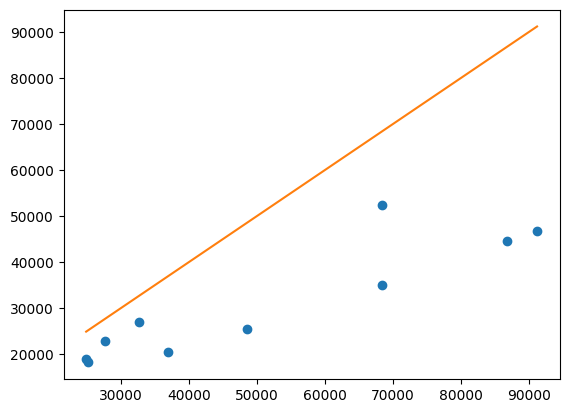

In [41]:
lb_quadratic_term = get_lb_quadratic_term(cond, p_x_tiled, y)[0]
plt.plot(sampled_quadratic_term, lb_quadratic_term, 'o')
plt.plot([jnp.amin(sampled_quadratic_term), jnp.amax(sampled_quadratic_term)], [jnp.amin(sampled_quadratic_term), jnp.amax(sampled_quadratic_term)])

In [43]:
def get_log_p_y(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray):
    lb_quadratic_term = get_lb_quadratic_term(cond, p_x, y)
    lb_log_det = get_lb_log_det(cond, p_x)
    lb_log_p_y = -.5 * (lb_quadratic_term + lb_log_det + Dy * jnp.log(2. * jnp.pi))[0]
    return lb_log_p_y

In [44]:
intgerate_jit_locally = jax.jit(get_log_p_y)
%timeit intgerate_jit_locally(cond, p_x_tiled, y)

30.2 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
integrate_jit = jax.jit(cond.integrate_log_conditional_y)
%timeit integrate_jit(p_x_tiled, y)

The slowest run took 5.54 times longer than the fastest. This could mean that an intermediate result is being cached.
26.1 µs ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
key = jax.random.PRNGKey(0)
x_samples = px.sample(key, 1000)
log_p_y_sampled = jnp.mean(cond(x_samples[:,0]).evaluate_ln(y), axis=0)

In [47]:
intgerate_jit_locally(cond, p_x_tiled, y) - integrate_jit(p_x_tiled, y)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [48]:
lb_log_p_y = get_log_p_y(cond, px, y)

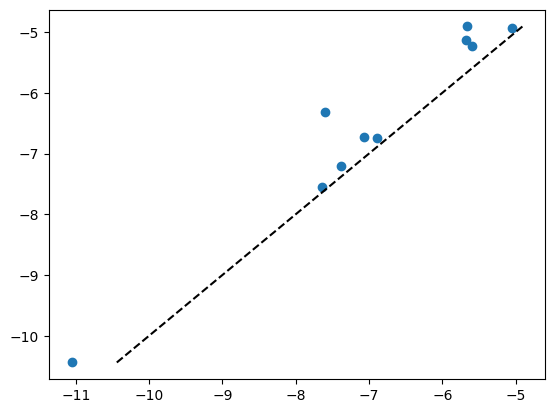

In [49]:
plt.plot(log_p_y_sampled, lb_log_p_y, 'o')
plt.plot([jnp.min(lb_log_p_y), jnp.max(lb_log_p_y)], [jnp.min(lb_log_p_y), jnp.max(lb_log_p_y)], 'k--')

In [39]:
cond.U.shape

AttributeError: 'FullHCCovGaussianConditional' object has no attribute 'U'

In [40]:
omega_star = _get_omega_star(cond, p_x_tiled, y, cond.W[0], cond.U[:,0])
omega_range = jnp.linspace(1e-3, 10., 100)[:,None]
rhs = jax.vmap(lambda omega: _update_omega_star(cond, p_x=p_x_tiled, y=y, W_i=cond.W[0], U_i=cond.U[:,0], omega_star=omega))(omega_range)

plt.plot(omega_range, rhs, "-")
plt.plot([0,10], [0,10], "--")
plt.plot(omega_star, omega_star, "o")
plt.ylim((jnp.min(rhs), jnp.max(rhs)))

AttributeError: 'FullHCCovGaussianConditional' object has no attribute 'U'

# Testing optimization

In [54]:
%load_ext autoreload
%autoreload 2

from gaussian_toolbox import pdf, approximate_conditional, factor
import numpy as np 
from jax import numpy as jnp
import jax
from matplotlib import pyplot as plt
from jax import config, lax
config.update("jax_enable_x64", True)

Dy = 1
Dx = 1
R = 1
Du = 1
Da = 1
Dk = 1
N = 1000

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
M = jax.random.normal(subkey, shape=(1, Dy, Dx))
b = jnp.array([jnp.zeros(Dy)])

#Sigma = jnp.array([jnp.eye(Dy)]) + .1
#mat = np.random.randn(Dy, Dy)
#Q, R = np.linalg.qr(mat)
#U = Q[:, :Du]
A = jnp.array(np.random.randn(1, Dy, Da)) / jnp.sqrt(Da)
W = jnp.array(np.random.randn(Dk, Dx + 1))
W = W.at[:, :1].set(0.)
W = W.at[0, 1:].set(-2.)
W = W.at[1, 1:].set(2.)

#cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
#cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
cond = approximate_conditional.HeteroscedasticExpConditional(M=M, b=b, A=A, W=W)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
N = 1000
key, subkey = jax.random.split(key)
y = jax.random.normal(key, (10, Dy))
key, subkey = jax.random.split(key)
mu = 1 * jax.random.normal(subkey, (N, Dx))
key, subkey = jax.random.split(key)
rand_mat = jax.random.uniform(subkey, (Dx, Dx))
Sigma_x = .01 * jnp.array(jnp.eye(Dx))[None]
px = pdf.GaussianPDF(mu=mu, Sigma=Sigma_x)
key, subkey = jax.random.split(key)
x_samples = px.sample(subkey, 1)[0]

In [56]:
key, subkey = jax.random.split(key)
y = cond(x_samples).sample(subkey, 1)[0]

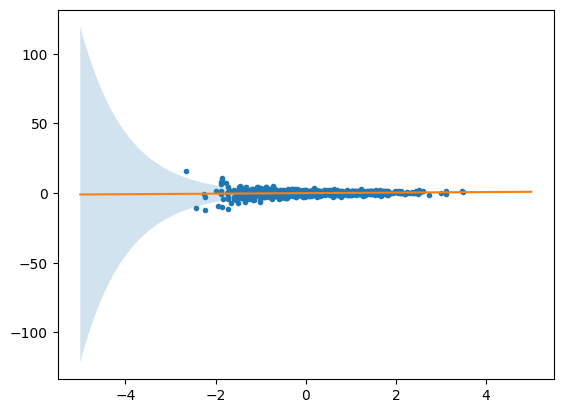

In [57]:
x_range = jnp.linspace(-5, 5, 1000)[:,None]
plt.plot(x_samples, y, '.')
plt.plot(x_range, cond(x_range).mu)
plt.fill_between(x_range[:,0], cond(x_range).mu[:,0] - jnp.sqrt(cond(x_range).Sigma[:,0,0]), cond(x_range).mu[:,0] + jnp.sqrt(cond(x_range).Sigma[:,0,0]), alpha=.2)

In [58]:

def objective(params):
    #W = jnp.hstack([jnp.zeros((Dk,1)),params['W']])
    W = params['W']
    cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
    return -jnp.sum(cond.integrate_log_conditional_y(px, y))

In [59]:
import jaxopt

key, subkey = jax.random.split(key)
solver = jaxopt.ScipyMinimize(method='CG', fun=objective)
#res = solver.run(init_params={'W': 1e-2 * jax.random.normal(subkey, (Dk, Dx+1))})
res = solver.run(init_params={'W': W})

(1000,) (1000,) (1000,)
(1, 1000)


In [60]:
W

Array([[ 0., -2.]], dtype=float64)

In [61]:
W_est = res.params['W']
#W_est = jnp.hstack([jnp.zeros((Dk,1)),res.params['W']])
cond_fit = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W_est)
W_est.shape, W.shape

W_est

Array([[-0.17182926, -1.91271271]], dtype=float64)

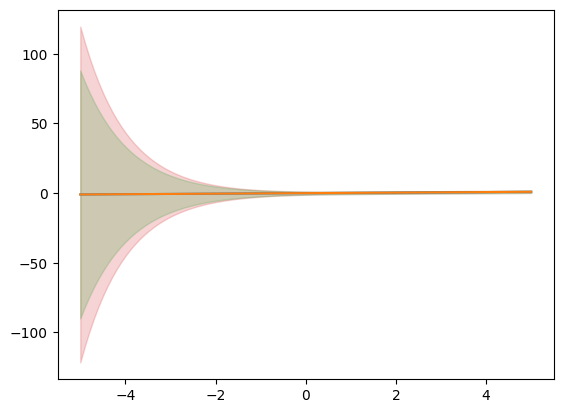

In [62]:
x_range = jnp.linspace(-5, 5, 100)[:,None]
#plt.plot(x_samples, y, '.', zorder=-1)
plt.plot(x_range, cond(x_range).mu)
plt.fill_between(x_range[:,0], cond(x_range).mu[:,0] - jnp.sqrt(cond(x_range).Sigma[:,0,0]), cond(x_range).mu[:,0] + jnp.sqrt(cond(x_range).Sigma[:,0,0]), alpha=.2, color='C3')
plt.plot(x_range, cond_fit(x_range).mu)
plt.fill_between(x_range[:,0], cond_fit(x_range).mu[:,0] - jnp.sqrt(cond_fit(x_range).Sigma[:,0,0]), 
                 cond_fit(x_range).mu[:,0] + jnp.sqrt(cond_fit(x_range).Sigma[:,0,0]), alpha=.2, color='C2')


In [63]:
%load_ext autoreload
%autoreload 2

from gaussian_toolbox import pdf, approximate_conditional, factor
import numpy as np 
from jax import numpy as jnp
import jax
from matplotlib import pyplot as plt
from jax import config, lax
config.update("jax_enable_x64", True)

Dy = 1
Dx = 1
R = 1
Du = 1
Da = 1
Dk =1
N = 1000

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
M = jax.random.normal(subkey, shape=(1, Dy, Dx))
b = jnp.array([jnp.zeros(Dy)])

#Sigma = jnp.array([jnp.eye(Dy)]) + .1
#mat = np.random.randn(Dy, Dy)
#Q, R = np.linalg.qr(mat)
#U = Q[:, :Du]
A = .2* jnp.array(np.random.randn(1, Dy, Da)) / jnp.sqrt(Da)
W = jnp.array(np.random.randn(Dk, Dx + 1))
W = W.at[0, 0].set(0.)

#cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
N = 1000
key, subkey = jax.random.split(key)
key, subkey = jax.random.split(key)
mu = 2 * jax.random.normal(subkey, (N, Dx))
key, subkey = jax.random.split(key)
rand_mat = jax.random.uniform(subkey, (Dx, Dx))
Sigma_x = jnp.tile(.01 * jnp.array(jnp.eye(Dx) + jnp.dot(rand_mat, rand_mat.T))[None], (N, 1, 1))
px = pdf.GaussianPDF(mu=mu, Sigma=Sigma_x)
key, subkey = jax.random.split(key)
x_samples = px.sample(subkey, 1)[0]
key, subkey = jax.random.split(key)
y = cond(x_samples).sample(subkey, 1)[0]

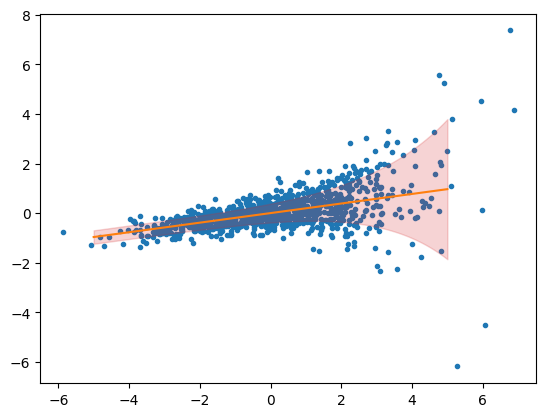

In [65]:
x_range = jnp.linspace(-5, 5, 100)[:,None]
plt.plot(x_samples, y, '.', zorder=-1)
plt.plot(x_range, cond(x_range).mu)
plt.fill_between(x_range[:,0], cond(x_range).mu[:,0] - jnp.sqrt(cond(x_range).Sigma[:,0,0]), cond(x_range).mu[:,0] + jnp.sqrt(cond(x_range).Sigma[:,0,0]), alpha=.2, color='C3')
#plt.plot(x_range, cond_fit(x_range).mu)
#plt.fill_between(x_range[:,0], cond_fit(x_range).mu[:,0] - jnp.sqrt(cond_fit(x_range).Sigma[:,0,0]), 
#                 cond_fit(x_range).mu[:,0] + jnp.sqrt(cond_fit(x_range).Sigma[:,0,0]), alpha=.2, color='C2')


In [66]:
def objective(params):
    #W = jnp.hstack([jnp.zeros((Dk,1)),params['W']])
    W = params['W']
    cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
    return -jnp.sum(cond.integrate_log_conditional_y(px, y))

In [67]:
import jaxopt

key, subkey = jax.random.split(key)
solver = jaxopt.ScipyMinimize(method='CG', fun=objective)
res = solver.run(init_params={'W': 1e-2 * jax.random.normal(subkey, (Dk, Dx+1))})
#res = solver.run(init_params={'W': W})

W_est = res.params['W']
#W_est = jnp.hstack([jnp.zeros((Dk,1)),res.params['W']])
cond_fit = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W_est)
W_est.shape, W.shape


(1000,) (1000,) (1000,)
(1, 1000)


((1, 2), (1, 2))

In [68]:
def objective_sample(params, key):
    W = params['W']
    key, subkey = jax.random.split(key)
    cond_tmp = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
    x_samples = px.sample(subkey, 1000)
    get_llk = lambda x: cond_tmp(x).evaluate_ln(y, element_wise=True)
    return -jnp.sum(jnp.mean(jax.vmap(get_llk)(x_samples), axis=0)), key

def objective(params):
    #W = jnp.hstack([jnp.zeros((Dk,1)),params['W']])
    W = params['W']
    cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
    return -jnp.sum(cond.integrate_log_conditional_y(px, y))

In [69]:
def log_det_objective_sample(params, key):
    W = params['W']
    key, subkey = jax.random.split(key)
    print(W.shape)
    cond_tmp = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
    x_samples = px.sample(subkey, 2000)
    _,_,log_det_sampled = jax.vmap(lambda x: cond_tmp.get_conditional_cov(x, True))(x_samples)
    print(log_det_sampled.shape)
    return jnp.sum(jnp.mean(log_det_sampled, axis=0)), key

def log_det_objective(params):
    #W = jnp.hstack([jnp.zeros((Dk,1)),params['W']])
    W = params['W']
    cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
    return jnp.sum(cond.get_lb_log_det(px))

In [70]:
def quadratic_objective_sample(params, key):
    W = params['W']
    key, subkey = jax.random.split(key)
    print(W.shape)
    cond_tmp = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
    x_samples = px.sample(subkey, 2000)
    mu_sampled = jax.vmap(lambda x: cond_tmp.get_conditional_mu(x))(x_samples)[:,0]
    _,Lambda_sampled,log_det_sampled = jax.vmap(lambda x: cond_tmp.get_conditional_cov(x, True))(x_samples)
    y_mu_sampled = y[None] - mu_sampled
    quadratic_term = jnp.einsum('abcd,abc,abd->ab', Lambda_sampled, y_mu_sampled, y_mu_sampled)
    #quadratic_term = jnp.einsum('cd,abc,abd->ab', cond.Lambda[0], y_mu_sampled, y_mu_sampled)
    return jnp.sum(jnp.mean(quadratic_term, axis=0)), key

def quadratic_objective(params):
    #W = jnp.hstack([jnp.zeros((Dk,1)),params['W']])
    W = params['W']
    cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)
    return jnp.sum(cond.get_lb_quadratic_term(px, y))

In [71]:
cond.R

1

In [72]:
b_range = jnp.linspace(-5, 5, 100)
W_range = jnp.linspace(-5, 5, 100)
mesh = jnp.meshgrid(b_range, W_range)
W_mesh = jnp.stack([mesh[0].flatten(), mesh[1].flatten()], axis=-1)

objective_arr = []
objective_sample_arr = []

objective_jit = jax.jit(objective)
objective_sample_jit = jax.jit(objective_sample)
#objective_jit = jax.jit(log_det_objective)
#objective_sample_jit = jax.jit(log_det_objective_sample)
#objective_jit = jax.jit(quadratic_objective)
#objective_sample_jit = jax.jit(quadratic_objective_sample)


for idx in range(W_mesh.shape[0]):
    objective_arr.append(objective_jit({'W': W_mesh[idx:idx+1]}))
    val, key = objective_sample_jit({'W': W_mesh[idx:idx+1]}, key)
    objective_sample_arr.append(val)
#cond_tmp = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=W[idx:idx+1])
#cond_fit = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=res_opt['W'])
objective_arr = jnp.array(objective_arr).reshape(mesh[0].shape)
objective_sample_arr = jnp.array(objective_sample_arr).reshape(mesh[0].shape)

(1000,) (1000,) (1000,)
(1, 1000)


KeyboardInterrupt: 

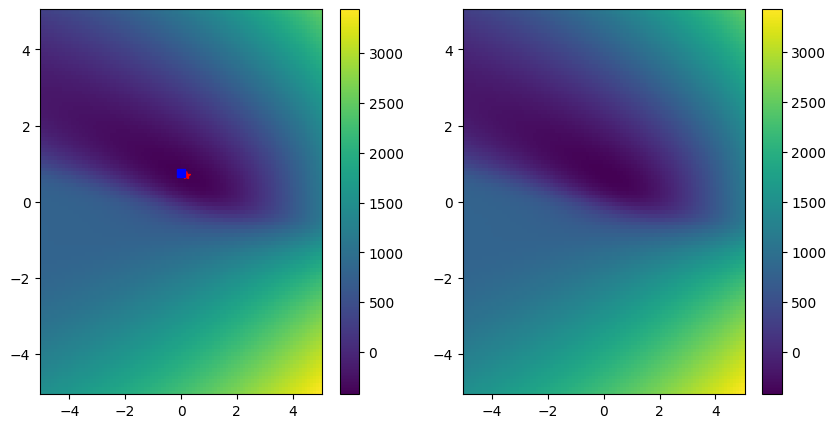

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.pcolor(mesh[0], mesh[1], objective_arr)
plt.plot(res.params['W'][0,0], res.params['W'][0,1], 'r*')
plt.plot(W[0,0], W[0,1], 'bs')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolor(mesh[0], mesh[1], objective_sample_arr)
plt.colorbar()

In [6]:
%load_ext autoreload
%autoreload 2

from gaussian_toolbox import pdf, approximate_conditional, factor
import numpy as np 
from jax import numpy as jnp
import jax
from matplotlib import pyplot as plt
from jax import config, lax
config.update("jax_enable_x64", True)

Dy = 1
Dx = 1
R = 1
Du = 1
N = 100

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
M = jax.random.normal(subkey, shape=(1, Dy, Dx))
b = jnp.array([jnp.zeros(Dy)])
Sigma_cond = .1 * jnp.array([jnp.eye(Dy)])
mat = np.random.randn(Dy, Dy)
Q, R = np.linalg.qr(mat)
U = Q[:, :Du]
W = jnp.array(np.random.randn(Du, Dx + 1))

cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=W)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: __init__() got unexpected kwargs: {'U'}.

In [ ]:
key, subkey = jax.random.split(key)
y = jax.random.normal(key, (10, Dy))
key, subkey = jax.random.split(key)
mu = jax.random.normal(subkey, (N, Dx))
key, subkey = jax.random.split(key)
rand_mat = jax.random.uniform(subkey, (Dx, Dx))
Sigma_x = 1. * jnp.array(jnp.eye(Dx) + jnp.dot(rand_mat, rand_mat.T))[None]
px = pdf.GaussianPDF(mu=mu, Sigma=Sigma_x)
key, subkey = jax.random.split(key)
x_samples = px.sample(subkey, 1)[0]

In [306]:
key, subkey = jax.random.split(key)
y = cond(x_samples).sample(subkey, 1)[0]

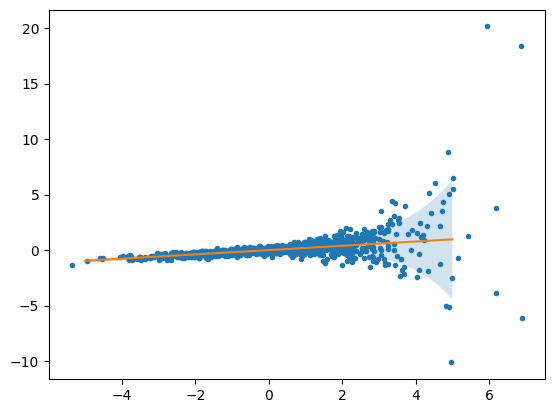

In [307]:
x_range = jnp.linspace(-5, 5, 100)[:,None]
plt.plot(x_samples, y, '.')
plt.plot(x_range, cond(x_range).mu)
plt.fill_between(x_range[:,0], cond(x_range).mu[:,0] - jnp.sqrt(cond(x_range).Sigma[:,0,0]), cond(x_range).mu[:,0] + jnp.sqrt(cond(x_range).Sigma[:,0,0]), alpha=.2)

In [308]:
def objective(params):
    W = params['W']
    cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=W)
    return -jnp.sum(cond.integrate_log_conditional_y(px, y))

import jaxopt

key, subkey = jax.random.split(key)
solver = jaxopt.ScipyMinimize(method='CG', fun=objective)
res = solver.run(init_params={'W': 1e-2 * jax.random.normal(subkey, W.shape)})
cond_fit = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=res.params['W'])

ValueError: __init__() got unexpected kwargs: {'U'}.

In [ ]:
x_range = jnp.linspace(-5, 5, 100)[:,None]
plt.plot(x_samples, y, 'k.', label='data')
#plt.plot(x_range, cond(x_range).mu)
plt.fill_between(x_range[:,0], cond(x_range).mu[:,0] - jnp.sqrt(cond(x_range).Sigma[:,0,0]), cond(x_range).mu[:,0] + jnp.sqrt(cond(x_range).Sigma[:,0,0]), alpha=.2, label='true')
#plt.plot(x_range, cond_fit(x_range).mu)
plt.fill_between(x_range[:,0], cond_fit(x_range).mu[:,0] - jnp.sqrt(cond_fit(x_range).Sigma[:,0,0]), 
                 cond_fit(x_range).mu[:,0] + jnp.sqrt(cond_fit(x_range).Sigma[:,0,0]), alpha=.2, label='fit')
plt.plot(x_range, px.evaluate(x_range).T - 6, 'k', alpha=.5, label='p(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['data', 'true', 'fit', 'p(x)'])
plt.title('High variance of x')
plt.show()


In [ ]:
x_samples[:,i].shape

In [ ]:
def objective_sample(params, key):
    W = params['W']
    key, subkey = jax.random.split(key)
    cond_tmp = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=W)
    x_samples = px.sample(subkey, 1000)
    log_likelihood = 0
    log_likelihood = lax.fori_loop(0, 100, lambda i, log_likelihood: log_likelihood + jnp.mean(cond_tmp(x_samples[:,i]).evaluate_ln(y[i][None])), log_likelihood)
    return -log_likelihood, key

In [ ]:
y.shape

In [ ]:
key, subkey = jax.random.split(key)
cond_tmp = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=W)
x_samples = px.sample(subkey, 1000)
i = 99
jnp.mean(cond_tmp(x_samples[:,i]).evaluate_ln(y[i:i+1]))

In [ ]:
b_range = jnp.linspace(-4, 4, 100)
W_range = jnp.linspace(-4, 4, 100)
mesh = jnp.meshgrid(b_range, W_range)
W_mesh = jnp.stack([mesh[0].flatten(), mesh[1].flatten()], axis=-1)

objective_arr = []
objective_sample_arr = []

objective_jit = jax.jit(objective)
objective_sample_jit = jax.jit(objective_sample)

for idx in range(W_mesh.shape[0]):
    objective_arr.append(objective_jit({'W': W_mesh[idx:idx+1]}))
    val, key = objective_sample_jit({'W': W_mesh[idx:idx+1]}, key)
    objective_sample_arr.append(val)
#cond_tmp = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=W[idx:idx+1])
#cond_fit = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, Sigma=Sigma_cond, U=U, W=res_opt['W'])
objective_arr = jnp.array(objective_arr).reshape(mesh[0].shape)
objective_sample_arr = jnp.array(objective_sample_arr).reshape(mesh[0].shape)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.pcolor(mesh[0], mesh[1], objective_arr)
plt.plot(res.params['W'][0,0], res.params['W'][0,1], 'r*', label='fit')
plt.plot(W[0,0], W[0,1], 'bs', label='true')
plt.legend()
plt.xlabel('b')
plt.ylabel('W')
plt.colorbar()
plt.title('lb loglikelihood')
plt.subplot(1,2,2)
plt.pcolor(mesh[0], mesh[1], objective_sample_arr)
plt.colorbar()
plt.title('sampled log likelihood')
plt.xlabel('b')

In [ ]:
objective({"W": cond.W})

In [ ]:
objective({"W": cond_fit.W})

In [ ]:
y

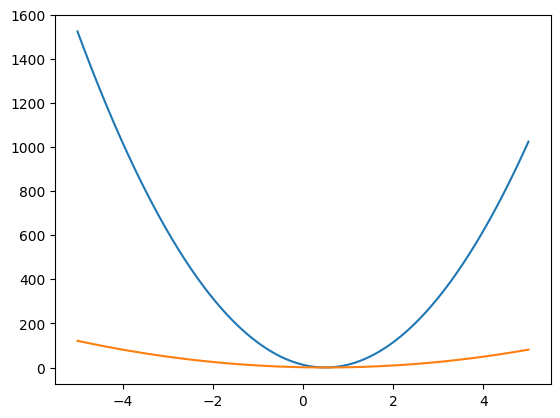

In [55]:
x_range = jnp.linspace(-5, 5, 100)[:,None]

sum_of_x2 = (x_range ** 2 + (10. * x_range - 5) ** 2) / 2
x2 = 4* (x_range - .5) ** 2  + .25
plt.plot(x_range, sum_of_x2, label='sum of x2')
plt.plot(x_range, x2, label='x2')

FullHSExpGaussianConditional(M=Array([[[-0.14413464,  0.89507787],
        [-0.46038094,  0.1050335 ],
        [-0.74608861,  0.89681112]]], dtype=float64), b=Array([[0., 0., 0.]], dtype=float64), Sigma=Array([[[ 5.65222646, -0.45912667,  2.57408149],
        [-0.45912667,  6.23530019, -1.27000246],
        [ 2.57408149, -1.27000246,  2.19007285]]], dtype=float64), Lambda=Array([[[ 0.41109346, -0.07726892, -0.52798234],
        [-0.07726892,  0.19638004,  0.20469621],
        [-0.52798234,  0.20469621,  1.19586627]]], dtype=float64), ln_det_Sigma=Array([3.37740626], dtype=float64), A=Array([[[-0.05653841,  2.24531622,  0.77947735],
        [ 0.9103801 ,  0.59845381, -2.24685587],
        [ 0.67070615,  0.79887519,  1.04977357]]], dtype=float64), W=Array([[-0.56756402, -0.19329031, -0.86363615]], dtype=float64), exp_h_plus=LinearFactor(Lambda=Array([[[0., 0.],
        [0., 0.]]], dtype=float64), nu=Array([[-0.19329031, -0.86363615]], dtype=float64), ln_beta=Array([-0.56756402], dtype=fl

In [ ]:
def _update_omega_star(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray, W_i: jnp.ndarray, a_i: jnp.ndarray, omega_star: jnp.ndarray):
    b = W_i[None,:1]
    w = W_i[None,1:]
    g_1 = .5 * jnp.tanh(omega_star/2.) / omega_star
    nu_1 = - .5 * ((jnp.tanh(omega_star/2.) / omega_star)[:,None] * b + 1) * w
    ln_beta_1 = - jnp.log(jnp.cosh(omega_star / 2.)) - .25 * jnp.tanh(omega_star / 2.) / omega_star * (b ** 2 - omega_star ** 2) - .5 * b - jnp.log(2.)
    phi = p_x.hadamard(factor.OneRankFactor(v=jnp.tile(w, (omega_star.shape[0], 1)), g=g_1, nu=nu_1, ln_beta=ln_beta_1), update_full=True)

    # Quartic integral

    projected_M = jnp.einsum('ab,cad->cbd', a_i[:,None], cond.M)
    projected_yb = jnp.einsum('ab,ca->cb', a_i[:,None], y - cond.b)
    quartic_integral = phi.integrate("(Ax+a)'(Bx+b)(Cx+c)'(Dx+d)", A_mat=w, a_vec=b, B_mat=w, b_vec=b, 
                                        C_mat=-projected_M, c_vec=projected_yb, D_mat=-projected_M, d_vec=projected_yb)
    # Quadratic integral
    quadratic_integral = phi.integrate("(Ax+a)'(Bx+b)", A_mat=-projected_M, a_vec=projected_yb, B_mat=-projected_M, b_vec=projected_yb)
    omega_star = jnp.sqrt(quartic_integral / quadratic_integral)[0]
    return omega_star

def _get_omega_star(cond, p_x: pdf.GaussianPDF, y: jnp.ndarray, W_i: jnp.ndarray, a_i: jnp.ndarray):
    omega_star = _get_omega_dagger(p_x=p_x, W_i=W_i)
    omega_dagger = omega_star + 1.
    cond_func = lambda val: jnp.max(jnp.abs(val[0] - val[1])) > 1e-5
    body_func = lambda val: (_update_omega_star(cond, p_x=p_x, y=y, W_i=W_i, a_i=a_i, omega_star=val[0]), val[0])
    omega_star, _ = lax.while_loop(cond_func, body_func, (omega_star, omega_dagger))
    return omega_star

In [7]:
%load_ext autoreload
%autoreload 2
from gaussian_toolbox import pdf, approximate_conditional, factor
import numpy as np 
from jax import numpy as jnp
import jax
from matplotlib import pyplot as plt
from jax import config
config.update("jax_enable_x64", True)

Dy = 3
Dx = 2
R = 1
Du = 1
Da = 4
Dk = 1
N = 1000

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
M = jax.random.normal(subkey, shape=(1, Dy, Dx))
b = jnp.array([jnp.zeros(Dy)])

#Sigma = jnp.array([jnp.eye(Dy)]) + .1
#mat = np.random.randn(Dy, Dy)
#Q, R = np.linalg.qr(mat)
#U = Q[:, :Du]
A = jnp.array(np.random.randn(1, Dy, Da)) / jnp.sqrt(Da)
W = jnp.array(np.random.randn(Dk, Dx + 1)) / Dx
W = W.at[0,0].set(0.)

#cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
i = 0 
b = cond.W[i,:1]
W = cond.W[i,1:]
A_inv = jnp.einsum('abc,acd->abd', cond.Lambda, cond.A[:,:,:cond.Dk])[0].T
a_i = A_inv[i]
h = lambda x: jnp.dot(x, W) + b

G_true = lambda x: 1. / (1. + jnp.exp(h(x)))
G_true2 = lambda x: .5* jnp.exp(- .5 * h(x)) / jnp.cosh(.5 * h(x))

k = lambda x, omega: jnp.log(jnp.cosh(.5* omega)) + .25 * jnp.tanh(.5 * omega) / omega * (h(x) ** 2 - omega ** 2)
G_lb = lambda x, omega: jnp.exp(- .5*h(x) - k(x, omega) - jnp.log(2.))

def get_G_lb_factor(omega):
    g = .5 * jnp.tanh(.5 * omega) / omega
    v = jnp.tile(W[None], (omega.shape[0], 1))
    nu = - .5 * ((jnp.tanh(.5 * omega) / omega) * b + 1)[:,None] * v
    ln_beta = - jnp.log(jnp.cosh(.5 * omega)) - .25 * jnp.tanh(.5 * omega) / omega * (b ** 2 - omega ** 2) - .5 * b - jnp.log(2.)
    return factor.OneRankFactor(v=v, g=g, nu=nu, ln_beta=ln_beta)

def G_lb2(x, omega):
    phi = get_G_lb_factor(omega)
    return phi(x)[0]
    
def get_expected_G_lb(px, omega):
    phi = get_G_lb_factor(omega)
    return px.hadamard(phi, update_full=True).integrate()

In [9]:

x_range = jnp.linspace(-15, 15, 100)[:,None]
assert jnp.alltrue(G_lb2(x_range, jnp.array([.01])) < G_true2(x_range))

TypeError: Incompatible shapes for dot: got (100, 1) and (2, 1).

In [4]:
W.shape, x_samples.shape

NameError: name 'x_samples' is not defined

In [5]:
omega = jnp.array([2])
plt.plot(x_range, G_true(x_range), label='G_true')
plt.plot(x_range, G_true2(x_range), label='G_true2', ls='--')
plt.plot(x_range, G_lb(x_range, omega), label='G_lb')
plt.plot(x_range, G_lb2(x_range, omega), label='G_lb2', ls='--')

TypeError: Incompatible shapes for dot: got (100, 1) and (2,).

In [711]:
num_samples = 10000
key, subkey = jax.random.split(key)
y = jax.random.normal(key, (10, Dy))
key, subkey = jax.random.split(key)
mu = jax.random.normal(subkey, (10,Dx))
key, subkey = jax.random.split(key)
rand_mat = jax.random.uniform(subkey, (Dx, Dx))
Sigma = jnp.tile(jnp.array(jnp.eye(Dx) + jnp.dot(rand_mat, rand_mat.T))[None], (10,1,1))
px = pdf.GaussianPDF(mu=mu, Sigma=Sigma)
key, subkey = jax.random.split(key)
x_samples = px.sample(subkey, num_samples)
key, subkey = jax.random.split(key)
x_samples2 = px.sample(subkey, num_samples)

In [714]:
expected_G_true = jax.vmap(G_true)(x_samples).mean(0)
expected_G_lb = get_expected_G_lb(px, omega)

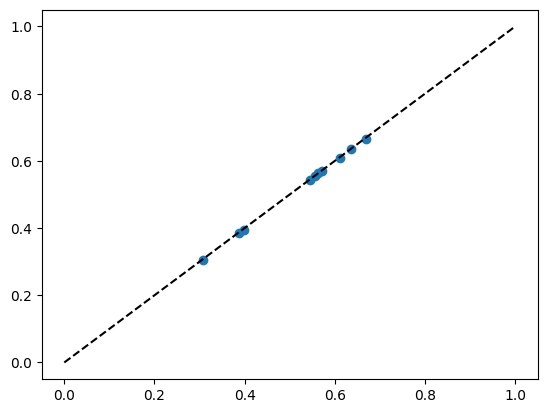

In [716]:
#assert jnp.alltrue(expected_G_true > expected_G_lb)
#plt.plot(expected_G_true, expected_G_lb, 'o')
plt.plot(expected_G_true, expected_G_lb, 'o')
plt.plot([0,1], [0,1], 'k--')

In [717]:
def get_heteroscedastic_term(x):
    mu_sampled = jax.vmap(cond.get_conditional_mu)(x)[:,0] - cond.b
    return (jnp.einsum('a,cda->cd', a_i, y[None] - mu_sampled) ** 2) * G_true2(x)

    #return jnp.sum((y[None] - mu_sampled) ** 2, axis=2) * G_true2(x)
def get_heteroscedastic_term_lb_sampled(x, omega):
    mu_sampled = jax.vmap(cond.get_conditional_mu)(x)[:,0] - cond.b
    g2lb = jax.vmap(lambda x: G_lb2(x, omega))(x)
    return (jnp.einsum('a,cda->cd', a_i, y[None] - mu_sampled) ** 2) * g2lb

def get_lb_heteroscedastic_term(px, omega):
    phi = get_G_lb_factor(omega)
    px_phi = px.hadamard(phi, update_full=True)
    a_projected_M = jnp.tile(jnp.einsum('ab,cad->cbd', a_i[:,None], cond.M), (y.shape[0], 1, 1))
    a_projected_yb = jnp.einsum('ab,ca->cb', a_i[:,None], y - cond.b)
    print(a_projected_M.shape, a_projected_yb.shape)
    #return px_phi.integrate("(Ax+a)'(Bx+b)", A_mat=-a_projected_M, a_vec=a_projected_yb, B_mat=-a_projected_M, b_vec=a_projected_yb)
    return px_phi.integrate("(Ax+a)'(Bx+b)", A_mat=-a_projected_M, a_vec=a_projected_yb, B_mat=-a_projected_M, b_vec=a_projected_yb)

In [718]:
phi = get_G_lb_factor(omega)
px_phi = px.hadamard(phi, update_full=True)
xx2_ana = px_phi.integrate("xx'")
MxxM_ana = jnp.einsum('abc,adc->abd', jnp.einsum('abc,acd->abd', cond.M, xx2_ana), cond.M)

In [719]:
aM = jnp.einsum('ab,cab->cb', a_i[:,None], cond.M)[None]
aMxxMa_ana = jnp.einsum('abc,adc->abd', jnp.einsum('abc,acd->abd', aM, xx2_ana), aM)

In [720]:
aMxxMa_ana2 = px_phi.integrate("(Ax+a)(Bx+b)'", A_mat=aM, B_mat=aM)

In [721]:
jnp.allclose(aMxxMa_ana, aMxxMa_ana2)

Array(True, dtype=bool)

In [724]:
g2lb = jax.vmap(lambda x: G_lb2(x, omega))(x_samples)
g2 = G_true(x_samples)
xx2_sampled= (g2[:,:,None,None] * x_samples[:,:,None] * x_samples[:,:,:,None])
xx2_sampled_lb= (g2lb[:,:,None,None] * x_samples2[:,:,None] * x_samples2[:,:,:,None])
aMxxMa_sampled = jnp.einsum('eabc,adc->eabd', jnp.einsum('abc,eacd->eabd', aM, xx2_sampled), aM)
aMxxMa_sampled_lb = jnp.einsum('eabc,adc->eabd', jnp.einsum('abc,eacd->eabd', aM, xx2_sampled_lb), aM)


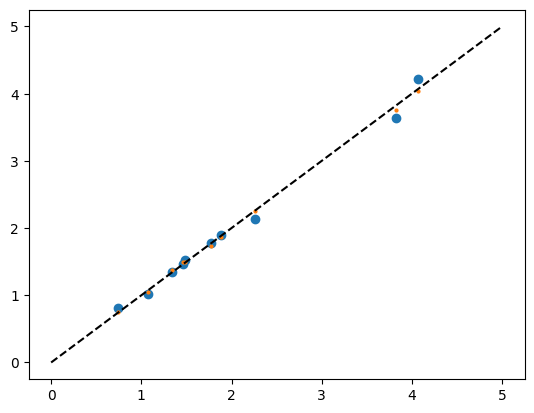

In [725]:
plt.plot(aMxxMa_sampled.mean(0).flatten(), aMxxMa_sampled_lb.mean(0).flatten(), 'o')
plt.plot(aMxxMa_sampled.mean(0).flatten(), aMxxMa_ana2.flatten(), 'o', ms=2)
plt.plot([0,5], [0,5], 'k--')

In [726]:
aMxxMa_sampled.mean(0) - aMxxMa_sampled_lb.mean(0)

Array([[[ 6.10958018e-02]],

       [[ 1.27311331e-01]],

       [[-3.56234354e-03]],

       [[ 1.82546879e-01]],

       [[-1.26739759e-04]],

       [[-1.94698132e-02]],

       [[-1.57709318e-01]],

       [[-4.10347029e-02]],

       [[-6.16216414e-02]],

       [[ 3.84510836e-03]]], dtype=float64)

In [727]:
a_projected_M = jnp.einsum('a,bac->bc', a_i, cond.M)
a_projected_yb = jnp.einsum('a,ba->b', a_i, y - cond.b)
a_projected_y_mu1 = jnp.einsum('ab,cdb->cda', -a_projected_M, x_samples) + a_projected_yb[None, :, None]
mu_sampled = jax.vmap(cond.get_conditional_mu)(x_samples)[:,0]
a_projected_y_mu2 = jnp.einsum('a,cda->cd', a_i, y[None] - mu_sampled)

(y - cond.b).shape
(a_projected_y_mu1[:,:,0] - a_projected_y_mu2)

Array([[-1.38777878e-17,  0.00000000e+00,  3.33066907e-16, ...,
         2.22044605e-16,  0.00000000e+00, -1.00613962e-16],
       [ 4.44089210e-16, -8.88178420e-16,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.44089210e-16, ...,
        -2.22044605e-16,  0.00000000e+00, -4.44089210e-16],
       ...,
       [ 0.00000000e+00,  4.44089210e-16,  0.00000000e+00, ...,
        -2.22044605e-16,  0.00000000e+00, -1.28369537e-16],
       [ 8.32667268e-17,  1.11022302e-16,  0.00000000e+00, ...,
         0.00000000e+00,  8.88178420e-16, -1.94289029e-16],
       [ 0.00000000e+00,  5.55111512e-17,  4.44089210e-16, ...,
        -3.33066907e-16,  0.00000000e+00, -2.22044605e-16]],      dtype=float64)

In [728]:
phi = get_G_lb_factor(omega)
x_samples.shape

(10000, 10, 2)

In [731]:
omega = jnp.ones(px.R)
heteroscedastic_term = get_heteroscedastic_term(x_samples).mean(0)
heteroscedastic_term_lb_sampled = get_heteroscedastic_term_lb_sampled(x_samples2, omega).mean(0)
lb_heteroscedastic_term = get_lb_heteroscedastic_term(px, omega)
assert jnp.alltrue(heteroscedastic_term > heteroscedastic_term_lb_sampled)
assert jnp.alltrue(heteroscedastic_term > lb_heteroscedastic_term)

(10, 1, 2) (10, 1)


AssertionError: 

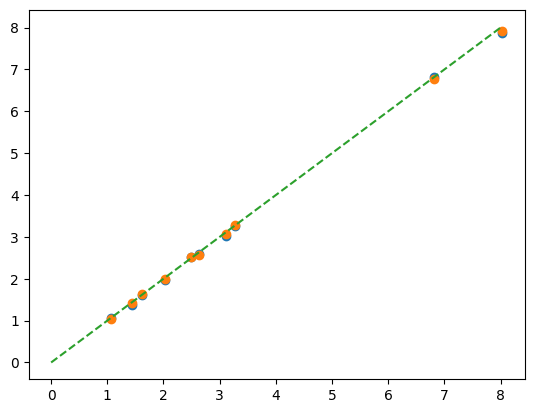

In [732]:
plt.plot(heteroscedastic_term, heteroscedastic_term_lb_sampled, 'o')
plt.plot(heteroscedastic_term, lb_heteroscedastic_term, 'o')
plt.plot([0, heteroscedastic_term.max()], [0, heteroscedastic_term.max()], '--')

In [733]:
heteroscedastic_term - lb_heteroscedastic_term

Array([ 0.06219254, -0.00889418,  0.00529453,  0.02618553,  0.04197858,
        0.02134852,  0.03881262,  0.03478384,  0.1052551 , -0.0461543 ],      dtype=float64)

In [734]:
def _update_omega_star(p_x, omega_star):
    phi = get_G_lb_factor(omega_star)
    px_phi = p_x.hadamard(phi, update_full=True)
    # Quartic integral
    a_projected_M = jnp.einsum('ab,cad->cbd', a_i[:,None], cond.M)
    a_projected_yb = jnp.einsum('ab,ca->cb', a_i[:,None], y - cond.b)
    quartic_integral = px_phi.integrate("(Ax+a)'(Bx+b)(Cx+c)'(Dx+d)", A_mat=W[None], a_vec=b, B_mat=W[None], b_vec=b, 
                                        C_mat=-a_projected_M, c_vec=a_projected_yb, D_mat=-a_projected_M, d_vec=a_projected_yb)
    # Quadratic integral
    quadratic_integral = px_phi.integrate("(Ax+a)'(Bx+b)", A_mat=-a_projected_M, a_vec=a_projected_yb, B_mat=-a_projected_M, b_vec=a_projected_yb)
    omega_star = jnp.sqrt(quartic_integral / quadratic_integral)
    return omega_star

In [735]:
omega_star = .01 * jnp.ones(px.R)
for i in range(10):
    print(omega_star)
    omega_star = _update_omega_star(px, omega_star)
    

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.60682956 0.91001371 0.6263513  0.67192887 0.76361232 0.71465246
 0.9617109  0.91784776 0.81611902 0.80823809]
[0.60765212 0.91412648 0.62730123 0.6732178  0.76570791 0.7163499
 0.96637428 0.92190599 0.81878946 0.81082085]
[0.60765428 0.91416107 0.62730401 0.67322255 0.76571883 0.7163576
 0.966416   0.92193933 0.81880594 0.81083643]
[0.60765429 0.91416136 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0

(10, 1, 2) (10, 1)


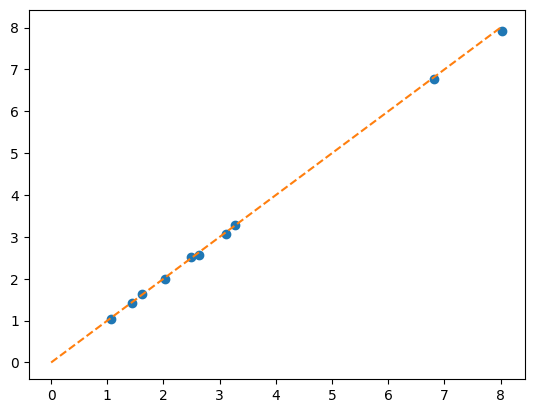

In [736]:
heteroscedastic_term = get_heteroscedastic_term(x_samples).mean(0)
lb_heteroscedastic_term = get_lb_heteroscedastic_term(px, omega_star)
plt.plot(heteroscedastic_term, lb_heteroscedastic_term, 'o')
plt.plot([0, heteroscedastic_term.max()], [0, heteroscedastic_term.max()], '--')

In [737]:
cond.get_lb_heteroscedastic_term_i(px, y, cond.W[i], A_inv[i])

Array([[2.57571877, 1.63181366, 3.28026339, 1.04940688, 3.07257955,
        1.41692605, 6.78094651, 1.99385519, 7.92509677, 2.53057062]],      dtype=float64)

In [738]:
lb_heteroscedastic_term

Array([2.57571877, 1.63181366, 3.28026339, 1.04940688, 3.07257955,
       1.41692605, 6.78094651, 1.99385519, 7.92509677, 2.53057062],      dtype=float64)

In [739]:
cond._get_omega_star(px, y, cond.W[i], A_inv[i])

Array([0.60765429, 0.91416136, 0.62730402, 0.67322257, 0.76571889,
       0.71635764, 0.96641637, 0.9219396 , 0.81880604, 0.81083653],      dtype=float64)

In [740]:
omega_star = .01 * jnp.ones(px.R)
omega_star2 = .01 * jnp.ones(px.R)
for i in range(10):
    print(omega_star)
    omega_star = _update_omega_star(px, omega_star)
    omega_star2 = cond._update_omega_star(px, y, cond.W[i], A_inv[i], omega_star2)

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.60682956 0.91001371 0.6263513  0.67192887 0.76361232 0.71465246
 0.9617109  0.91784776 0.81611902 0.80823809]
[0.60765212 0.91412648 0.62730123 0.6732178  0.76570791 0.7163499
 0.96637428 0.92190599 0.81878946 0.81082085]
[0.60765428 0.91416107 0.62730401 0.67322255 0.76571883 0.7163576
 0.966416   0.92193933 0.81880594 0.81083643]
[0.60765429 0.91416136 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0.76571889 0.71635764
 0.96641637 0.9219396  0.81880604 0.81083653]
[0.60765429 0.91416137 0.62730402 0.67322257 0

In [741]:
omega_star2 - omega_star

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [742]:
cond.get_lb_heteroscedastic_term_i(px, y, cond.W[i], A_inv[i])

Array([[2.57571877, 1.63181366, 3.28026339, 1.04940688, 3.07257955,
        1.41692605, 6.78094651, 1.99385519, 7.92509677, 2.53057062]],      dtype=float64)

In [743]:
lb_heteroscedastic_term = get_lb_heteroscedastic_term(px, omega_star)
lb_heteroscedastic_term

(10, 1, 2) (10, 1)


Array([2.57571877, 1.63181366, 3.28026339, 1.04940688, 3.07257955,
       1.41692605, 6.78094651, 1.99385519, 7.92509677, 2.53057062],      dtype=float64)

In [744]:
G_true2(x_samples)

Array([[0.54351177, 0.74665714, 0.61718395, ..., 0.74790065, 0.27644486,
        0.61968111],
       [0.37412765, 0.87768731, 0.82039728, ..., 0.54071041, 0.30025725,
        0.39051468],
       [0.47471224, 0.46900891, 0.72078986, ..., 0.6194226 , 0.17403029,
        0.61168743],
       ...,
       [0.2614156 , 0.46852665, 0.6243315 , ..., 0.68990234, 0.25609355,
        0.54209807],
       [0.18440008, 0.49268757, 0.72836385, ..., 0.81374247, 0.17221252,
        0.78186668],
       [0.58267201, 0.66132001, 0.46221612, ..., 0.7948553 , 0.58306883,
        0.75551114]], dtype=float64)

In [ ]:
%load_ext autoreload
%autoreload 2

from gaussian_toolbox import pdf, approximate_conditional, factor
import numpy as np 
from jax import numpy as jnp
import jax
from matplotlib import pyplot as plt
from jax import config, lax
config.update("jax_enable_x64", True)

Dy = 1
Dx = 2
R = 1
Du = 1
Da = 1
Dk =1
N = 1000

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
M = jax.random.normal(subkey, shape=(1, Dy, Dx))
b = jnp.array([jnp.zeros(Dy)])

#Sigma = jnp.array([jnp.eye(Dy)]) + .1
#mat = np.random.randn(Dy, Dy)
#Q, R = np.linalg.qr(mat)
#U = Q[:, :Du]
A = .2* jnp.array(np.random.randn(1, Dy, Da)) / jnp.sqrt(Da)
W = jnp.array(np.random.randn(Dk, Dx + 1))
W = W.at[0, 0].set(0.)

#cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
cond = approximate_conditional.FullHSExpGaussianConditional(M=M, b=b, A=A, W=W)

In [4]:
%load_ext autoreload
%autoreload 2

from gaussian_toolbox import pdf, approximate_conditional, factor
import numpy as np 
from jax import numpy as jnp
import jax
from matplotlib import pyplot as plt
from jax import config, lax
config.update("jax_enable_x64", True)

Dy = 1
Dx = 1
Da = 1
Dk = 1
R = 1
Du = 1

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
M = jax.random.normal(subkey, shape=(1, Dy, Dx))
b = jnp.array([jnp.zeros(Dy)])

#Sigma = jnp.array([jnp.eye(Dy)]) + .1
#mat = np.random.randn(Dy, Dy)
#Q, R = np.linalg.qr(mat)
#U = Q[:, :Du]
A = jnp.array(np.random.randn(1, Dy, Da))
W = jnp.array(np.random.randn(Dk, Dx + 1))

#cond = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
cond1 = approximate_conditional.FullHCCovGaussianConditional(M=M, b=b, A=A, W=W)
cond2 = approximate_conditional.HeteroscedasticCoshM1Conditional(M=M, b=b, A=A, W=W)
num_samples = 1000
key, subkey = jax.random.split(key)
y = jax.random.normal(key, (10, Dy))
key, subkey = jax.random.split(key)
mu = jax.random.normal(subkey, (1,Dx))
key, subkey = jax.random.split(key)
rand_mat = jax.random.uniform(subkey, (Dx, Dx))
Sigma = jnp.array(jnp.eye(Dx) + jnp.dot(rand_mat, rand_mat.T))[None]
px = pdf.GaussianPDF(mu=mu, Sigma=Sigma)
p_x_tiled = pdf.GaussianPDF(mu=jnp.tile(mu, (y.shape[0], 1)), Sigma=jnp.tile(Sigma, (y.shape[0], 1, 1)))
key, subkey = jax.random.split(key)
x_samples = px.sample(subkey, num_samples)[:,0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
lb_log_det1 = cond1.get_lb_log_det(px)
lb_log_det2 = cond2.get_lb_log_det(px)
lb_log_det1 == lb_log_det2

(1, 1)


Array([ True], dtype=bool)

In [6]:
lb_quadratic1 = cond1.get_lb_quadratic_term(p_x_tiled, y)
lb_quadratic2 = cond2.get_lb_quadratic_term(p_x_tiled, y)

In [7]:
lb_quadratic1, lb_quadratic2

(Array([[0.18366369, 0.05123345, 1.08212067, 0.02662088, 0.08120565,
         2.07380423, 0.02725532, 0.108457  , 0.01871537, 0.25928103]],      dtype=float64),
 Array([[0.18366369, 0.05123345, 1.08212067, 0.02662088, 0.08120565,
         2.07380423, 0.02725532, 0.108457  , 0.01871537, 0.25928103]],      dtype=float64))

In [5]:
projected_M = jnp.einsum('acb,acd->abd', cond1.Lambda, cond1.M)
projected_yb = jnp.einsum('acb,ac->ab', cond1.Lambda, y - cond1.b)
homoscedastic_term1 = p_x_tiled.integrate("(Ax+a)'(Bx+b)", A_mat=-projected_M, a_vec=projected_yb, B_mat=-cond1.M, b_vec=y - cond1.b)

projected_M = jnp.einsum('acb,acd->abd', cond2.Lambda, cond2.M)
projected_yb = jnp.einsum('acb,ac->ab', cond2.Lambda, y - cond2.b)
homoscedastic_term2 = p_x_tiled.integrate("(Ax+a)'(Bx+b)", A_mat=-projected_M, a_vec=projected_yb, B_mat=-cond2.M, b_vec=y - cond2.b)

homoscedastic_term1 - homoscedastic_term2


Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [15]:
A_inv = jnp.einsum('abc,acd->abd', cond1.Lambda, cond1.A[:,:,:cond1.Dk])[0]
omega_dagger = cond1._get_omega_dagger(p_x_tiled, cond1.W[0])

In [16]:
A_inv = jnp.einsum('abc,acd->abd', cond1.Lambda, cond1.A[:,:,:cond1.Dk])[0]
cond1._get_omega_star(p_x_tiled, y, cond1.W[0], A_inv[:,0]) 

Array([2.35907382, 2.06533204, 1.78824729, 2.81033621, 1.3214299 ,
       2.14423371, 2.80521188, 2.42484894, 2.7221159 , 2.31932413],      dtype=float64)

In [17]:
A_inv = jnp.einsum('abc,acd->abd', cond2.Lambda, cond2.A[:,:,:cond2.Dk])[0]
jnp.sqrt(cond2._get_omega_star(p_x_tiled, y, cond2.W[0], A_inv[:,0]))

Array([4.11734019, 4.12080563, 4.1309679 , 4.12016619, 4.12140742,
       4.11371839, 4.12018808, 4.11786219, 4.11936195, 4.11695161],      dtype=float64)

In [34]:
from jaxtyping import Float, Array
def get_lb_heteroscedastic_term_i(self, omega_star, p_x: pdf.GaussianPDF, y: Float[Array, "N Dy"], 
                                      W_i: Float[Array, "Dx+1"], a_i: Float[Array, "Dy"]):
    #omega_star = lax.stop_gradient(self._get_omega_star(p_x=p_x, y=y, W_i=W_i, a_i=a_i))
    b = W_i[None,:1]
    w = W_i[None,1:]
    g_1 = jnp.tanh(omega_star) / omega_star
    nu_1 = - (jnp.tanh(omega_star) / omega_star)[:,None] * b * w
    ln_beta_1 = - jnp.log(jnp.cosh(omega_star)) - .5 * jnp.tanh(omega_star) / omega_star * (b ** 2 - omega_star ** 2)
    print(g_1, nu_1, ln_beta_1)
    phi_1 = p_x.hadamard(factor.OneRankFactor(v=jnp.tile(w, (omega_star.shape[0], 1)), g=g_1, nu=nu_1, ln_beta=ln_beta_1), update_full=True)
    phi_plus = phi_1.hadamard(factor.LinearFactor(nu=w, ln_beta=b-jnp.log(2.)), update_full=True)
    phi_minus = phi_1.hadamard(factor.LinearFactor(nu=-w, ln_beta=-b-jnp.log(2.)), update_full=True)
    # Quadratic integral
    U_projected_M = jnp.einsum('ab,cad->cbd', a_i[:,None], self.M)
    U_projected_yb = jnp.einsum('ab,ca->cb', a_i[:,None], y - self.b)
    quadratic_1 = phi_1.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)
    quadratic_plus = phi_plus.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)
    quadratic_minus = phi_minus.integrate("(Ax+a)'(Bx+b)", A_mat=-U_projected_M, a_vec=U_projected_yb, B_mat=-U_projected_M, b_vec=U_projected_yb)
    G_i = - quadratic_1 + quadratic_plus + quadratic_minus
    return G_i
    

In [32]:
get_lb_heteroscedastic_term_i(cond1, omega_dagger, p_x_tiled, y, cond1.W[0], A_inv[:,0])

[0.57060712 0.57060712 0.57060712 0.57060712 0.57060712 0.57060712
 0.57060712 0.57060712 0.57060712 0.57060712] [[0.24568672]
 [0.24568672]
 [0.24568672]
 [0.24568672]
 [0.24568672]
 [0.24568672]
 [0.24568672]
 [0.24568672]
 [0.24568672]
 [0.24568672]] [[-0.30454514 -0.30454514 -0.30454514 -0.30454514 -0.30454514 -0.30454514
  -0.30454514 -0.30454514 -0.30454514 -0.30454514]]


Array([[0.17390596, 0.01026486, 0.45016731, 0.0113658 , 0.01645817,
        1.36295812, 0.01117779, 0.116815  , 0.027029  , 0.22791714]],      dtype=float64)

In [33]:
cond2._lower_bound_integrals(p_x_tiled, y, cond2.W[0], A_inv[:,0], omega_dagger, False)

[0.57060712 0.57060712 0.57060712 0.57060712 0.57060712 0.57060712
 0.57060712 0.57060712 0.57060712 0.57060712] [[0.24568672 0.24568672 0.24568672 0.24568672 0.24568672 0.24568672
  0.24568672 0.24568672 0.24568672 0.24568672]] [[-0.30454514 -0.30454514 -0.30454514 -0.30454514 -0.30454514 -0.30454514
  -0.30454514 -0.30454514 -0.30454514 -0.30454514]]


Array([[4.56442553e+25, 2.02964051e+25, 1.49317199e+24, 2.35228247e+25,
        1.76664861e+25, 1.15219525e+26, 2.34042396e+25, 4.02918512e+25,
        2.83381811e+25, 5.01355293e+25]], dtype=float64)